In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
!pip install opendatasets
%matplotlib inline
import opendatasets as od
import PIL.Image as Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf
import datetime, os
from tensorflow.keras.callbacks import TensorBoard
from tqdm import tqdm
from numpy.linalg import norm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Downloading Dataset
#{"username":"bibekchand","key":"a3505d98121625269732648261f97bb2"}
od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small")

Skipping, found downloaded files in "./fashion-product-images-small" (use force=True to force download)


In [ ]:
Path = "/content/fashion-product-images-small"
print(os.listdir(Path))

['styles.csv', 'images', 'myntradataset']


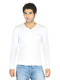

In [ ]:
#Observing the Sample
Image.open(Path + '/images/' + str(20000)+'.jpg')

In [ ]:
df = pd.read_csv (Path+ "/styles.csv", nrows=44000, error_bad_lines=False)
df.head(10)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 1

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [ ]:
#Building the dataframe with image-id and articletype
type_image = pd.DataFrame()
type_image['filename'] = df['id']
type_image['type'] =df['articleType']

In [ ]:
type_image

,filename,type
0,15970,Shirts
1,39386,Jeans
2,59263,Watches
3,21379,Track Pants
4,53759,Tshirts
...,...,...
43995,50154,Heels
43996,34411,Tshirts
43997,44766,Casual Shoes
43998,37294,Watches


In [ ]:
def file_jpg(x):
  return(str(x)+'.jpg')

type_image['filename'] = type_image['filename'].apply(file_jpg)





In [ ]:
type_image

,filename,type
0,15970.jpg,Shirts
1,39386.jpg,Jeans
2,59263.jpg,Watches
3,21379.jpg,Track Pants
4,53759.jpg,Tshirts
...,...,...
43995,50154.jpg,Heels
43996,34411.jpg,Tshirts
43997,44766.jpg,Casual Shoes
43998,37294.jpg,Watches


In [ ]:
#Assign unique numeric value to types
values = list(type_image['type'].unique())
def label(i):

  return values.index(i)

type_image['type_label'] = type_image['type'].apply(label)

In [ ]:
len(values) # There are 143 classes in the dataset

143

In [ ]:
type_image

,filename,type,type_label
0,15970.jpg,Shirts,0
1,39386.jpg,Jeans,1
2,59263.jpg,Watches,2
3,21379.jpg,Track Pants,3
4,53759.jpg,Tshirts,4
...,...,...,...
43995,50154.jpg,Heels,27
43996,34411.jpg,Tshirts,4
43997,44766.jpg,Casual Shoes,6
43998,37294.jpg,Watches,2


In [ ]:
#plotting the data
plt.figure(figsize=(20,10))
type_image['type'].value_counts().plot(kind='bar',x='type',y='filename')
plt.show()

In [ ]:
# Getting X as image data and Y as label for number_values
def Data(start,stop):
    x_data = []
    y_data = []


    for i in range(start,stop):


        Image_path=Path+"/images"+"/"+type_image.loc[i,'filename']

        image = cv2.imread(Image_path,cv2.IMREAD_GRAYSCALE)
        try:
            resized_img = cv2.resize(image, dsize=(28, 28))
        except:
            print("Rejected Image: "+type_image.loc[i,'filename'])
            continue


        x_data.append(resized_img)
        y_values = type_image.loc[i,'type_label']
        y_data.append(y_values)

    return x_data, y_data

In [ ]:
X=[]
Y=[]
start = 0
stop = len(type_image)
X,Y=Data(start,stop)

In [ ]:
plt.imshow(X[10])

In [ ]:
#Converting X and Y to numpy array and normalizing the x-label
X = np.array(X).reshape(-1, 28,28,1)
Y = np.array(Y)
X = X/255.0

In [ ]:
X[0]

In [ ]:
print("Shape of X is",X.shape)
print("Shape of Y is",Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 500)

In [ ]:
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Test Image Data Shape: ',X_test.shape)
print('Test Label Data Shape: ',Y_test.shape)


In [ ]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 500)

In [ ]:
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Validation Image Data Shape: ',X_validate.shape)
print('Validation Label Data Shape: ',Y_validate.shape)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), input_shape = (28,28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), input_shape = (28,28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units = len(values), activation = 'softmax'))
    return model


In [ ]:
model=build_model()

In [ ]:
print(model.summary())

In [ ]:
def train_model(model):
    model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = 150, verbose = 1, validation_data = (X_validate, Y_validate))

In [ ]:
train_model(model)

In [ ]:
print(feature_list)

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [ ]:
prediction = model.predict(X_test)

In [ ]:
print(values[np.argmax(prediction[100])])
print(values[Y_test[100]])

In [ ]:
L = 10
W = 5
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, 50):
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"PC = {values[np.argmax(prediction[i])]}\n TC = {values[Y_test[i]]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [ ]:

img_1 = plt.imread("/content/images.jpeg")
plt.imshow(img_1)

In [ ]:
def make_prediction(img):
    img = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(img, dsize=(28, 28))
    x_data = np.array(resized_img).reshape(-1, 28,28,1)
    x_data=x_data/255
#     print(x_data)
#     print(x_data.shape)
    result=model.predict(x_data)
#     print(type(result))
 #   print(np.argmax(result))
    return x_data,values[np.argmax(result)]

In [ ]:
numpy_image,result=make_prediction(img_1)
print(result)

In [ ]:
X.shape

In [ ]:
features_list = []

result = model.predict(X)




In [ ]:
expanded_img_array1 = np.expand_dims(X_test[100], axis = 0)

In [ ]:
p = model.predict(expanded_img_array1)

In [ ]:
result.shape

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,algorithm='auto',metric='euclidean')
neighbors.fit(result)
distances,indices = neighbors.kneighbors(p)


In [ ]:
for i in indices[0]:
  print(type_image['filename'][i])

In [ ]:
Image.open(Path + '/images/' + str(18694)+'.jpg')

In [ ]:
plt.imshow(X_test[100].reshape(28,28))

NameError: name 'plt' is not defined